# MLMAPPER USING NEURAL NETWORK

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2


### DATA PATH

In [3]:
#paths to data 
albedo="/home/gokul/g0kul6/ml4sci/Data_Albedo/Albedo_Map.csv"
LPFe_Map="/home/gokul/g0kul6/ml4sci/Data_Albedo/LPFe_Map.csv"
LPK_Map="/home/gokul/g0kul6/ml4sci/Data_Albedo/LPK_Map.csv"
LPTh_Map="/home/gokul/g0kul6/ml4sci/Data_Albedo/LPTh_Map.csv"
LPTi_Map="/home/gokul/g0kul6/ml4sci/Data_Albedo/LPTi_Map.csv"

### CUSTOM DATASET TO GET INPUT,GT

In [4]:
#custom dataset
class dataset(Dataset):
  def __init__(self,path_1,path_2,path_3,path_4,path_5,start_split,end_split):
    self.path_1=path_1
    self.path_2=path_2
    self.path_3=path_3
    self.path_4=path_4
    self.path_5=path_5
    self.start_split=start_split
    self.end_split=end_split
    self.X_1=torch.FloatTensor(np.array(pd.read_csv(path_1)))
    self.X_2=torch.FloatTensor(np.array(pd.read_csv(path_2)))
    self.X_3=torch.FloatTensor(np.array(pd.read_csv(path_3)))
    self.X_4=torch.FloatTensor(np.array(pd.read_csv(path_4)))
    self.X_5=torch.FloatTensor(np.array(pd.read_csv(path_5)))
    self.X_1=(self.X_1[:,self.start_split:self.end_split].flatten()-torch.mean(self.X_1[:,self.start_split:self.end_split].flatten()))/torch.std(self.X_1[:,self.start_split:self.end_split].flatten())
    self.X_2=(self.X_2[:,self.start_split:self.end_split].flatten()-torch.mean(self.X_2[:,self.start_split:self.end_split].flatten()))/torch.std(self.X_2[:,self.start_split:self.end_split].flatten())
    self.X_3=(self.X_3[:,self.start_split:self.end_split].flatten()-torch.mean(self.X_3[:,self.start_split:self.end_split].flatten()))/torch.std(self.X_3[:,self.start_split:self.end_split].flatten())
    self.X_4=(self.X_4[:,self.start_split:self.end_split].flatten()-torch.mean(self.X_4[:,self.start_split:self.end_split].flatten()))/torch.std(self.X_4[:,self.start_split:self.end_split].flatten())
    self.X_5=self.X_5[:,self.start_split:self.end_split].flatten()
    self.X=torch.stack((self.X_1,self.X_2,self.X_3,self.X_4),1)  
    self.Y=self.X_5
  
  def __len__(self):
    self.filelength=len(self.Y)
    return self.filelength

  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

### NEURAL NETWORK MODEL

In [13]:
#neural network model
class model(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(model, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden,n_hidden)
        self.hidden3 = torch.nn.Linear(n_hidden,n_hidden)    
        self.predict = torch.nn.Linear(n_hidden, n_output)   
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.dropout(F.relu(self.hidden1(x)))
        x = self.dropout(F.relu(self.hidden2(x)))
        x = self.dropout(F.relu(self.hidden3(x)))      
        x = self.predict(x)            
        return x

### Train Function:

In [118]:
class train():
    def __init__(self,batch_size,epochs,lr,train_val_split):
        self.batch_size=batch_size
        self.epochs=epochs
        self.lr=lr
        self.train_val_split=train_val_split
        self.data=dataset(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,0,360)
        self.train_data,self.val_data=random_split(self.data,[len(self.data)-int(self.train_val_split*len(self.data)),int(self.train_val_split*len(self.data))],generator=torch.Generator().manual_seed(42))
        self.train_loader=DataLoader(self.train_data,batch_size=self.batch_size,shuffle=True)
        self.val_loader=DataLoader(self.val_data,batch_size=self.batch_size,shuffle=True)
        self.net=model(n_feature=4, n_hidden=10, n_output=1)  
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        #self.scheduler=torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma=0.9)
        self.loss_func = torch.nn.MSELoss() 
        self.writer = SummaryWriter()
    def trainer(self):
        self.net=self.net.train()
        self.net=self.net.cuda()
        for epoch in range(self.epochs):
            for input,gt in self.train_loader:
                input = input.cuda()
                gt = gt.cuda()
                gt=torch.reshape(gt,(len(gt),1))
                output = self.net(input)
                loss = self.loss_func(output, gt)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            #self.scheduler.step()
            print('Epoch : {},  train loss : {}'.format(epoch+1,loss.item()))
            with torch.no_grad():
                for input,gt in self.val_loader:
                    input=input.cuda()
                    gt= gt.cuda()
                    gt=torch.reshape(gt,(len(gt),1))
                    val_output = self.net(input)
                    val_loss = self.loss_func(val_output,gt)
            print('Epoch : {},  val_loss : {}'.format(epoch+1,val_loss.item()))
            self.writer.add_scalar("Loss/train", loss, epoch)
            self.writer.add_scalar("Loss/val", val_loss, epoch)
        torch.save(self.net.state_dict(),f"albedo_{self.epochs}_{self.lr}.pth")
train_best=train(batch_size=128,epochs=200,lr=0.00001,train_val_split=0.3)

# TRAINING:
#### Model that I am using is a neural network with 3-hidden layers,activation function as RELU and dropout with p=0.2
#### model(
#####  (hidden1): Linear(in_features=4, out_features=10, bias=True)
#####  (hidden2): Linear(in_features=10, out_features=10, bias=True)
#####  (hidden3): Linear(in_features=10, out_features=10, bias=True)
#####  (predict): Linear(in_features=10, out_features=1, bias=True)
#####  (dropout): Dropout(p=0.2, inplace=False)
)
#### Loss function = Mean Squared Error Loss(MSE)
#### Optimizer     = Adam 
#### After a lot of hyper-parameter tuning the model showed convergance and better results for lr=0.00001,batchsize=128,train-validatio=70-30 

## LOSS-EPOCH GRAPH FOR TRAIN,VALIDATION
<img align='center' src='https://github.com/g0kul6/Albedo_Task_ML4SCi/blob/main/images/train-val-loss_curves.png' >

### As you can see the loss-epoch curve for both train and validation are smoothly converging. Also validation curve is not noisy.

# Test

In [16]:
test_data=dataset(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,360,720)
test_loader=DataLoader(test_data,batch_size=1)
loss_function=torch.nn.MSELoss()
net_test=model(4,10,1)
net_test=net_test.eval().cuda()
net_test.load_state_dict(torch.load("/home/gokul/g0kul6/ml4sci/Albedo_Task_ML4SCi/albedo_200_1e-05.pth"))
right_predicted=[]
right_truth=np.array(pd.read_csv(albedo))[:,360:720]
total_loss=[]
for i,l in test_loader:
    i=i.cuda()
    l=l.cuda()
    l=torch.reshape(l,(len(l),1))
    output=net_test(i)
    loss=loss_function(output,l)
    loss=loss.cpu().item()
    total_loss.append(np.sqrt(loss))
    right_predicted.append(output.cpu().item())
print("RMSE Loss on right half :",np.mean(total_loss))
right_predicted=np.reshape(right_predicted,(359,360))
residual=right_predicted-right_truth

RMSE Loss on right half : 0.026970662753440646


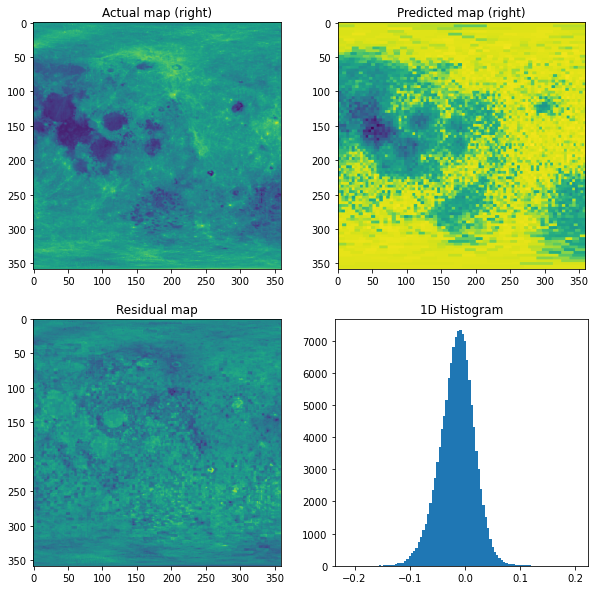

In [15]:
ffig, faxes = plt.subplots(2, 2, figsize=(10, 10))
faxes[0, 0].imshow(right_truth)
faxes[0, 0].set_title("Actual map (right)")
faxes[0, 0].grid(False)

faxes[0, 1].imshow(right_predicted)
faxes[0, 1].set_title("Predicted map (right)")
faxes[0, 1].grid(False)

faxes[1, 0].imshow(residual)
faxes[1, 0].set_title("Residual map")
faxes[1, 0].grid(False)

faxes[1, 1].hist(residual.flatten(), bins=100)
faxes[1, 1].set_title("1D Histogram")
faxes[1, 1].grid(False)